# Mô hình với Keras và TensorFlow
> Chúng ta sẽ cùng đi qua về framework của Keras và Tensorflow để hiểu thêm được cách thức thực hiện xây dựng một mô hình phân loại hình ảnh với framework khác với fastai và pytorch.

In [1]:
import tensorflow as tf
from tensorflow import keras as K
import numpy as np

**Kiểm tra version của tensorflow và số lượng GPU**

In [2]:
print(tf.__version__)

2.3.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Tạo dữ liệu

### Sử dụng `image_dataset_from_directory`

Với tensorflow verion 2.3, chúng ta có thể sử dụng `keras.preprocessing` để load dữ liệu từ folder thông qua phương thức `image_dataset_from_directory`. Các version thấp hơn, chúng ta phải khá vất vả để xử lý dữ liệu từ folder giống như cách fastai đang làm.

In [4]:
home = '/home/ddpham/practice/projects/swift_swallow'
# home = '/path/to/your/project'
!ls {home}

data  fastai_model.ipynb  fastai_model_old.ipynb


In [5]:
bs = 32
train_ds = K.preprocessing.image_dataset_from_directory(
    f'{home}/data/train/'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=bs
    , image_size=(224, 224)
)

valid_ds = K.preprocessing.image_dataset_from_directory(
    f'{home}/data/valid/'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=bs
    , image_size=(224, 224)
)

Found 716 files belonging to 2 classes.
Found 207 files belonging to 2 classes.


**Lưu ý:** 

Ở đây chúng ta chỉ thuần túy tạo dữ liệu bằng cách load các hình ảnh từ folder đã được cấu trúc sẵn mà không có bất kỳ bước biến đổi dữ liệu nào cả (data augmentation). Tất nhiên, chúng ta sẽ làm việc sửa kích cỡ của hình ảnh cho phù hợp với mô hình chúng ta sử dụng.

Chúng ta có thể thấy dữ liệu đã được load lên. Tuy nhiên, có thể thấy là dữ liệu được load toàn bộ lên GPU. Đây là điểm trừ khá lớn của dataset của Tensorflow. 

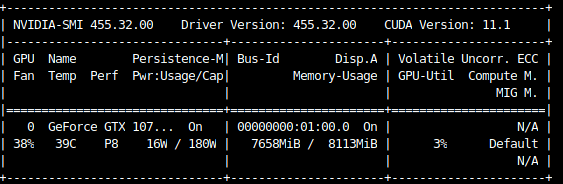

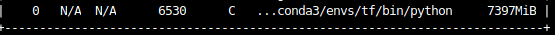

Trong khi đó với fastai, dữ liệu được tạo ra lại tương đối nhỏ:

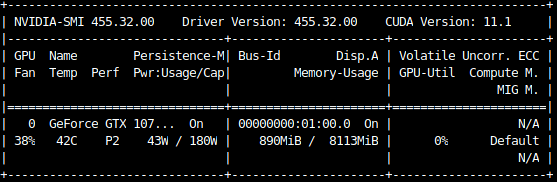



Lý do là vì với fastai, dữ liệu của 1 batch sẽ được load vào GPU và xử lý trước, trong quá trình train mô hình, dữ liệu sẽ tiếp tục được load vào gpu để xử lý, đảm bảo gpu không bị chiếm quá nhiều dung lượng. Trong khi đó, với tensorflow, toàn bộ dữ liệu sẽ được load vào GPU. Nên với GPU không thực sự lớn, các bạn có thể bị rơi vào tình trạng tràn bộ nhớ của GPU.

**Kiểm tra dữ liệu:**

In [6]:
from matplotlib import pyplot as plt

In [8]:
np.shape(train_ds.take(1))

()

TypeError: only integer scalar arrays can be converted to a scalar index

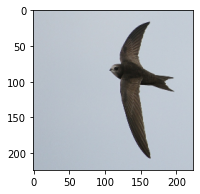

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.uint8(images[i]))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Xây dựng mô hình

### RESNET

Tương tự như fastai, chúng ta cũng sẽ sử dụng lại mô hình đã được học rồi để áp dụng vào bài toán của chúng ta.

**Lưu ý:**

Khác với fastai, với Keras/Tensorflow, để sử dụng mô hình đã học rồi, chúng ta hoặc sẽ sử dụng toàn bộ kiến trúc cũ, hoặc sẽ phải cắt bỏ phần lớp (layers) cuối cùng của kiến trúc cũ để tinh chỉnh theo bài toán mà chúng ta cần. Keras có cho lựa chọn `include_top` để chúng ta có thể thực hiện được việc này.


In [10]:
model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape=[224, 224, 3])

Xem kiến trúc của mô hình:

In [11]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

**Bổ sung lớp cần thiết cho bài toán của chúng ta:**

Chúng ta sẽ cần bổ sung thêm 2 lớp nữa cho mô hình đã học rồi:

1. Flatten: Kéo dãn dữ liệu đầu vào (3 chiều) của lớp trước thành array 1 chiều.
2. Dense: tạo lớp cơ bản và trả về kết quả dự đoán 2 giá trị.

In [18]:
flatten = K.layers.Flatten()(model.output)
predictions = K.layers.Dense(2, activation='sigmoid', name="predictions")(flatten)
new_model = K.models.Model(inputs=model.input, outputs=predictions)
new_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

**Tổng hợp mô hình:**

Với Keras, sau khi đã xây dựng xong kiến trúc, chúng ta cần tổng hợp lại mô hình và bổ sung phần còn lại của mô hình bao gồm:

- optimizer: thuật toán tối ưu sử dụng 
- loss: hàm mất mát
- metrics: các chỉ số được sử dụng

Với `leaner` và `cnn_learner` của fastai, chúng ta cũng có bước tương tự như vậy, tuy nhiên một vài thông số chúng ta có thể để mặc định được do các thông số này đã được tối ưu hóa. Ví dụ optimizer của fastai thực tế là `adam`, trong khi ở đây chúng ta đang sử dụng `rmsprop`.

Để nói thêm về thuật toán tối ưu sẽ mất khá nhiều thời gian, vì đây là phần cốt lõi (building bloc) của học sâu và mạng thần kinh (Neural Network), và luôn được gắn liền với tốc độ học (learning rate). Tương tự như vậy là `Initialization` và `Activation fuction`.

In [19]:
auc = K.metrics.AUC()
new_model.compile(optimizer='rmsprop', loss="binary_crossentropy", metrics=['accuracy', auc])

Chúng ta sẽ làm thêm một việc nữa là "đóng băng" các lớp trước của mô hình đã học. Sau khi chúng ta có kết quả tốt rồi, việc "giã đông" để học lại với các lớp trước sẽ là bước cuối cùng.

In [20]:
for layer in new_model.layers[:-2]:
    layer.trainable = False

In [21]:
new_model.fit(train_ds, epochs=10, validation_data=valid_ds)

Epoch 1/10
23/23 [==============================] - 22s 953ms/step - loss: 7.3213 - accuracy: 0.6816 - auc_1: 0.7354 - val_loss: 2.1197 - val_accuracy: 0.8116 - val_auc_1: 0.8481
Epoch 2/10
23/23 [==============================] - 6s 264ms/step - loss: 1.4087 - accuracy: 0.8827 - auc_1: 0.9069 - val_loss: 2.4481 - val_accuracy: 0.8357 - val_auc_1: 0.8566
Epoch 3/10
23/23 [==============================] - 6s 254ms/step - loss: 1.1761 - accuracy: 0.9455 - auc_1: 0.9408 - val_loss: 2.5164 - val_accuracy: 0.8357 - val_auc_1: 0.8502
Epoch 4/10
23/23 [==============================] - 6s 251ms/step - loss: 0.6485 - accuracy: 0.9581 - auc_1: 0.9561 - val_loss: 3.0994 - val_accuracy: 0.8068 - val_auc_1: 0.8382
Epoch 5/10
23/23 [==============================] - 6s 257ms/step - loss: 0.3027 - accuracy: 0.9846 - auc_1: 0.9850 - val_loss: 2.8160 - val_accuracy: 0.8454 - val_auc_1: 0.8661
Epoch 6/10
23/23 [==============================] - 6s 251ms/step - loss: 0.1262 - accuracy: 0.9916 - auc_1: 

Chúng ta có thể thấy được chỉ với 10 epoch thôi, mô hình của chúng ta đã cho ra kết quả accuracy của tập train rất cao, nhưng accuracy của tập valid lại thấp hơn tới 15%. Điều đó cho thấy mô hình của chúng ta đang bị overfit. 

Chúng ta có thể cải thiện kết quả này hơn thông qua các bước sau:
1. Cải thiện dữ liệu đầu vào (thông qua việc biến đổi dữ liệu - data augmentation) - ở đây chúng ta chỉ thuần túy load dữ liệu vào mà thôi.
2. Cải thiện việc sử dụng tốc độ học (learning rate). Hiện chúng ta đang để `lr` dưới dạng default.

Chúng ta sẽ thử cả 2 cách trên với Keras. Đây chính là điểm khác biệt giữa Keras/Tensorflow với fastai, với những người mới học hoặc kể cả những người đã có kinh nghiệm, việc tối ưu mô hình học sâu tốn kém thời gian cũng như công sức và tiền của, nên hay để cho các chuyên gia làm việc này và chúng ta chỉ cần thừa hưởng lại những kết quả này thôi.